In [24]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

### Calculating a composite of soil moisture data with the North Atlantic Oscilliation index

The North Atlantic Oscillation(NAO) consists of a north-south dipole of height and pressure anomalies, with one center located over Greenland, and the other located in the Atlantic between 35 and 40 degrees North. Changes in the NAO can affect temperature and precipitation patterns in eastern North America and Europe. More information can be found on the Climate Prediction Center (CPC) website here: https://www.cpc.ncep.noaa.gov/data/teledoc/nao.shtml

Import the North Atlantic Oscillation Index and format the data:

In [25]:
path='/shared/ccsm4/kpegion/obs2/CLIM_INDICES/'
file='nao.data'
index_name='nao'

df=pd.read_table(path+file,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True)
df.drop(df.tail(3).index,inplace=True)
df

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
1948,-99.90,-99.90,-99.90,-99.90,-99.90,-99.90,-99.90,-99.90,-99.90,-99.90,-99.90,-99.90
1949,-99.90,-99.90,-99.90,-99.90,-99.90,-99.90,-99.90,-99.90,-99.90,-99.90,-99.90,-99.90
1950,0.56,0.01,-0.78,0.65,-0.50,0.25,-1.23,-0.19,0.39,1.43,-1.46,-1.03
1951,-0.42,0.35,-1.47,-0.38,-0.50,-1.35,1.39,-0.41,-1.18,2.54,-0.54,1.13
1952,0.57,-1.38,-1.97,0.95,-0.99,-0.10,-0.06,-0.49,-0.38,-0.28,-1.32,-0.49
...,...,...,...,...,...,...,...,...,...,...,...,...
2016,-0.37,1.35,0.37,0.26,-0.67,-0.13,-1.72,-2.24,0.74,0.96,-0.31,0.35
2017,0.05,0.69,0.37,1.74,-1.72,0.35,1.28,-1.53,-0.45,0.71,-0.14,0.73
2018,1.17,1.34,-1.38,1.20,2.02,1.41,1.42,2.40,1.78,1.53,-0.25,0.48


In [26]:
start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-01'
print(start_date)

1948-1-01


In [27]:
dates=pd.date_range(start=start_date,end=end_date,freq='MS')
dates

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=876, freq='MS')

In [28]:
clim_index=df.T.unstack().values
clim_index=clim_index.astype('float32')
nao_index=xr.DataArray(clim_index,
                      coords={'time':dates},
                              dims=['time'])        
nao_index=nao_index.to_dataset(name='nao')
nao_index

<xarray.Dataset>
Dimensions:  (time: 876)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2020-12-01
Data variables:
    nao      (time) float32 -99.9 -99.9 -99.9 -99.9 ... 1.11 -99.9 -99.9 -99.9

The first two years and last three months of this data are not available. Delete those months.

In [29]:
nao_index=nao_index.sel(time=slice(nao_index['time'][24],nao_index['time'][-4]))
nao_index

<xarray.Dataset>
Dimensions:  (time: 849)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2020-09-01
Data variables:
    nao      (time) float32 0.56 0.01 -0.78 0.65 -0.5 ... 0.16 -1.19 0.03 1.11

Import the Soil Moisture data. This is model calculated CPC soil moisture data from NOAA.

In [30]:
sw = xr.open_dataset("/scratch/dklein3/soilw.mon.mean.v2.nc")
sw

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 884)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-08-01
Data variables:
    soilw    (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    title:          CPC Soil Moisture
    institution:    NOAA/ESRL PSD
    dataset_title:  CPC Soil Moisture
    history:        Wed Oct 18 15:13:37 2017: ncks -d time,,-2 soilw.mon.mean...
    NCO:            4.6.9
    References:     https://www.psl.noaa.gov/data/gridded/data.cpcsoil.html

Match the timeframe to the NAO index timeframe.

In [31]:
sw=sw.sel(time=slice(nao_index['time'][0],nao_index['time'][-1]))
sw

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 849)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2020-09-01
Data variables:
    soilw    (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    title:          CPC Soil Moisture
    institution:    NOAA/ESRL PSD
    dataset_title:  CPC Soil Moisture
    history:        Wed Oct 18 15:13:37 2017: ncks -d time,,-2 soilw.mon.mean...
    NCO:            4.6.9
    References:     https://www.psl.noaa.gov/data/gridded/data.cpcsoil.html

The NAO index is defined as positive and negative. Create datasets of positive and negative NAO index months.

In [32]:
pos_nao=nao_index['nao'].where(nao_index['nao']>=0)
neg_nao=nao_index['nao'].where(nao_index['nao']<0)
pos_nao

<xarray.DataArray 'nao' (time: 849)>
array([0.56, 0.01,  nan, 0.65,  nan, 0.25,  nan,  nan, 0.39, 1.43,  nan,
        nan,  nan, 0.35,  nan,  nan,  nan,  nan, 1.39,  nan,  nan, 2.54,
        nan, 1.13, 0.57,  nan,  nan, 0.95,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, 1.41, 0.43,  nan,
        nan, 1.95, 0.96,  nan,  nan, 0.4 ,  nan, 1.31,  nan, 0.06,  nan,
        nan,  nan, 1.16, 0.29, 0.55,  nan,  nan,  nan,  nan,  nan,  nan,
       1.78, 1.25, 0.46,  nan,  nan, 0.07,  nan,  nan,  nan,  nan, 2.1 ,
       0.41,  nan,  nan, 0.38, 1.47, 0.4 , 0.  , 0.71,  nan,  nan, 0.39,
        nan,  nan,  nan,  nan,  nan, 1.95, 0.63, 0.02,  nan,  nan,  nan,
       0.26,  nan,  nan,  nan,  nan, 0.08, 0.68, 1.59,  nan,  nan, 0.33,
        nan, 0.25, 0.41, 0.71, 0.77,  nan, 1.  , 1.48, 0.3 , 0.32,  nan,
        nan,  nan, 1.33, 0.47, 0.1 , 0.38,  nan, 0.53,  nan,  nan,  nan,
        nan, 0.07, 0.17,  nan,  nan, 1.17,  nan, 1.03, 1.36, 1.07,  nan,
        nan, 0.2 , 0.18,  nan, 0.93,  nan, 0.47,  nan, 0.05,  nan, 0.96,
        nan,  nan,  nan,  nan,  nan,  nan, 2.05,  nan,  nan,  nan, 1.89,
       1.53,  nan,  nan,  nan,  nan,  nan, 0.25, 0.53, 1.61, 1.92,  nan,
       0.34, 1.32,  nan,  nan,  nan,  nan,  nan, 0.64,  nan, 0.6 , 0.35,
       0.45, 0.51, 0.92,  nan, 1.18,  nan,  nan, 0.18,  nan, 0.25, 1.37,
       0.35,  nan,  nan,  nan,  nan, 0.58,  nan,  nan, 1.18, 0.05,  nan,
       1.72, 0.44, 1.73, 1.05, 0.59, 0.5 ,  nan,  nan,  nan, 0.02,  nan,
...
        nan,  nan, 0.06, 0.24, 0.16,  nan, 0.16,  nan, 0.77, 0.5 ,  nan,
        nan, 0.67, 1.11, 0.23,  nan, 1.16,  nan, 0.52,  nan, 0.63, 1.03,
       1.26,  nan,  nan,  nan,  nan, 0.26,  nan, 0.35, 0.76,  nan,  nan,
        nan, 0.97,  nan,  nan, 1.2 ,  nan, 1.15, 0.93,  nan,  nan,  nan,
       0.33, 1.15,  nan,  nan, 1.11, 0.04, 0.66,  nan,  nan,  nan, 0.85,
       1.  , 0.48, 0.23, 0.53, 0.38,  nan,  nan,  nan,  nan,  nan,  nan,
       1.14, 0.47,  nan,  nan,  nan,  nan, 0.19,  nan, 1.61,  nan,  nan,
        nan, 1.62,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan, 0.35, 0.24, 2.55,  nan,
        nan,  nan,  nan, 0.67, 0.94, 1.3 , 2.25, 0.86, 0.03, 0.93, 0.37,
        nan,  nan,  nan,  nan,  nan,  nan,  nan, 0.07,  nan,  nan,  nan,
       0.6 , 0.58, 0.83, 0.7 , 1.12, 0.38,  nan, 0.81, 0.79,  nan, 1.07,
       0.44, 0.19,  nan,  nan, 0.21,  nan, 1.72,  nan, 0.58, 1.63, 1.57,
       1.05, 1.12, 0.64, 0.19, 0.24,  nan,  nan,  nan, 0.99, 1.7 , 1.99,
        nan, 1.35, 0.37, 0.26,  nan,  nan,  nan,  nan, 0.74, 0.96,  nan,
       0.35, 0.05, 0.69, 0.37, 1.74,  nan, 0.35, 1.28,  nan,  nan, 0.71,
        nan, 0.73, 1.17, 1.34,  nan, 1.2 , 2.02, 1.41, 1.42, 2.4 , 1.78,
       1.53,  nan, 0.48, 0.18,  nan, 0.89, 0.36,  nan,  nan,  nan,  nan,
        nan,  nan, 0.16, 1.02, 1.05, 0.98, 0.66,  nan,  nan, 0.16,  nan,
       0.03, 1.11], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2020-09-01

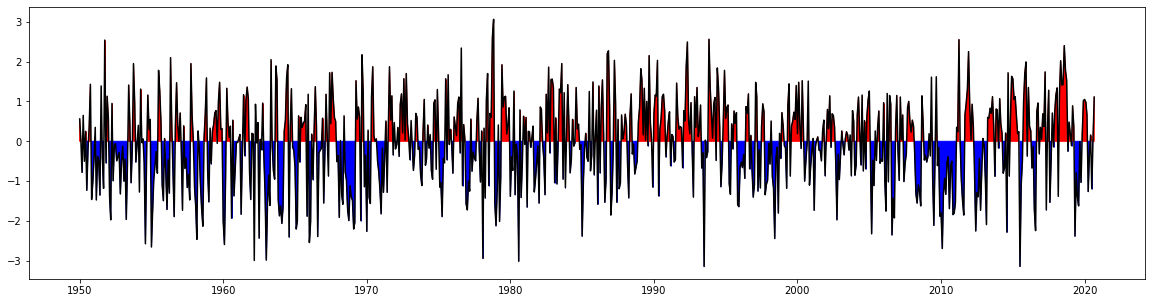

In [33]:
plt.figure(figsize=(20,5))
plt.plot(nao_index['time'],nao_index['nao'],'k')
plt.fill_between(nao_index['time'],0,pos_nao,color='red')
plt.fill_between(nao_index['time'],0,neg_nao,color='blue')

Calculate soil moisture anomalies

In [34]:
sw_climo=sw.groupby('time.month').mean()
sw_anom=sw.groupby('time.month')-sw_climo
sw_anom

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 849)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2020-09-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 ... 11 12 1 2 3 4 5 6 7 8 9
Data variables:
    soilw    (time, lat, lon) float32 nan nan nan nan ... 429.5 429.6 429.6

Adjust the month coordinates from numbers to months

In [35]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sw_climo = sw_climo.assign_coords({"month": ("month",months)})
sw_climo

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, month: 12)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * month    (month) <U3 'Jan' 'Feb' 'Mar' 'Apr' ... 'Sep' 'Oct' 'Nov' 'Dec'
Data variables:
    soilw    (month, lat, lon) float32 nan nan nan nan ... 3.672 3.679 3.676

Select the dates that match positive and negative NAO

In [36]:
pos_nao_sw=sw_anom.sel(time=pos_nao.dropna(dim='time')['time']).mean(dim='time')
neg_nao_sw=sw_anom.sel(time=neg_nao.dropna(dim='time')['time']).mean(dim='time')
comp_sw=[pos_nao_sw,neg_nao_sw]
comp_sw

[<xarray.Dataset>
 Dimensions:  (lat: 360, lon: 720)
 Coordinates:
   * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
   * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
 Data variables:
     soilw    (lat, lon) float32 nan nan nan nan nan ... 1.411 1.414 1.416 1.415,
 <xarray.Dataset>
 Dimensions:  (lat: 360, lon: 720)
 Coordinates:
   * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
   * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
 Data variables:
     soilw    (lat, lon) float32 nan nan nan nan ... -1.401 -1.404 -1.406 -1.405]

Create the composite map

Text(0.5, 0.98, 'Composite Soil Moisture Anomalies with NAO')

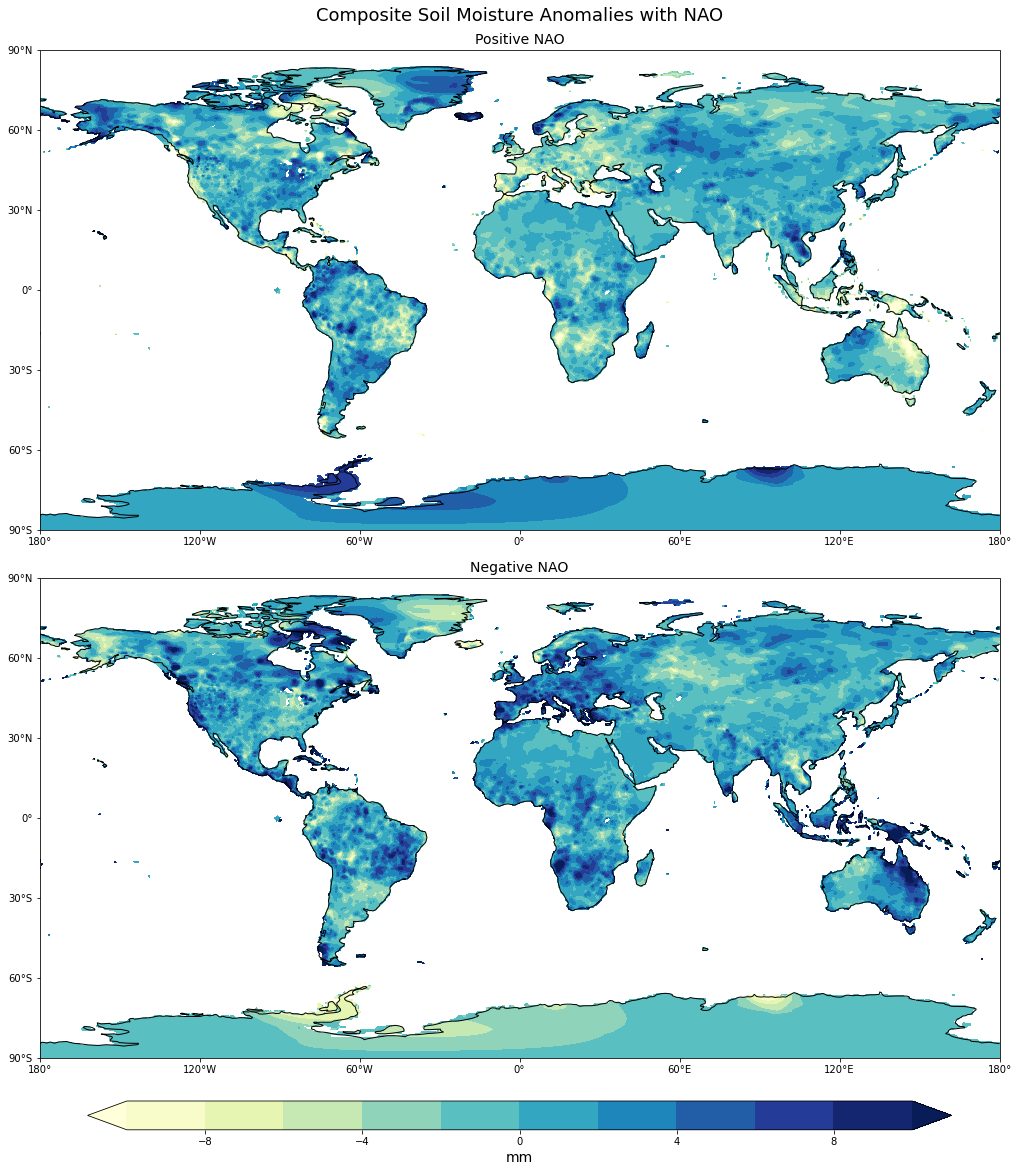

In [41]:
labels=['Positive NAO','Negative NAO']
clevs=np.arange(-10,12,2)

# Define the figure and each axis for the 2 rows and 1 column
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,20))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over the positive and negative NAO and plot
for i,index in enumerate(comp_sw):

        # Select the season
        data=comp_sw[i]['soilw']

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=comp_sw[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_sw[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='YlGnBu',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot
        axs[i].set_title(labels[i],fontsize=14)

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.95, wspace=0.1, hspace=0.1)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm')
cbar.set_label(label='mm',size=14)

# Add a big title at the top
plt.suptitle('Composite Soil Moisture Anomalies with NAO', fontsize=18)